# Skin Disease Classification Using ConvNeXt Model

### Description:

The **Skin Disease Classification System** is an application based on deep learning and computer vision techniques, designed to classify skin disease images. The model is built using **ConvNeXt**, a convolutional neural network, to accurately classify skin disease images into **20 different categories**.

The trained model can predict skin diseases from unseen images and report both the predicted class and confidence score.

### Key Features:
- Multi-class skin disease classification (20 classes)
- ConvNeXt-Tiny pretrained CNN architecture
- Class imbalance handling using weighted loss
- Confusion matrix and classification report analysis
- Single-image prediction with confidence score



In [3]:
!pip install opendatasets

# 1. Download the dataset

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/pacificrm/skindiseasedataset'
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/pacificrm/skindiseasedataset


100%|██████████| 1.36G/1.36G [00:11<00:00, 124MB/s]


In [5]:
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/train/Benign_tumors
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/train/Eczema
!rm -rf /content/skindiseasedataset/SkinDisease/SkinDisease/test/Eczema

# 2. Visualize Sample Images

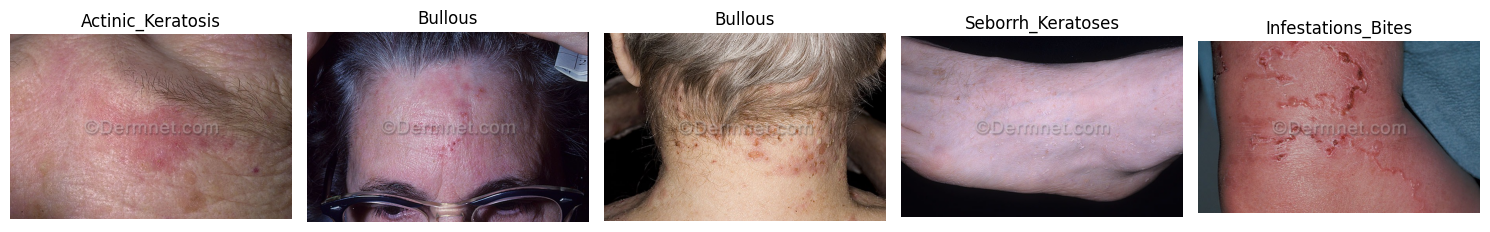

In [6]:
import random
from torchvision import datasets
import os
import matplotlib.pyplot as plt
import numpy as np

DATA_DIR = '/content/skindiseasedataset/SkinDisease/SkinDisease/'

sample_images = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "train")
)

def visualize_samples(dataset, n=5):
    random.seed(2)
    indices = random.sample(range(len(dataset)), n)

    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]   # image is PIL Image

        axes[i].imshow(image)         # ✅ directly show PIL image
        axes[i].set_title(f"{dataset.classes[label]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_samples(sample_images, n=5)


# 3. Import libraries

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 4. Prepare Skin Disease Image Dataset for Deep Learning

This section prepares the dataset for training a deep learning model for skin disease classification using PyTorch.  
It includes image transformations, dataset loading, and data loader creation.

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader

# ---------------- CONFIG ----------------

DATA_DIR = '/content/skindiseasedataset/SkinDisease/SkinDisease/'
BATCH_SIZE = 16
NUM_WORKERS = 4
NUM_CLASSES = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- TRANSFORMS ----------------

weights = models.ConvNeXt_Tiny_Weights.DEFAULT

train_transform = transforms.Compose([
    transforms.RandomResizedCrop( 224, scale=(0.7, 1.0), ratio=(0.9, 1.1) ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter( brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02 ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ---------------- DATASETS ----------------

train_ds = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "train"),
    transform=train_transform
)

val_ds = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "test"),
    transform=val_transform
)

# ---------------- DATALOADERS ----------------

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=NUM_WORKERS > 0
)

print(f"📊 Training images: {len(train_ds)} | Validation images: {len(val_ds)}")


📊 Training images: 11795 | Validation images: 1313


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
class_names = train_ds.classes
print(f"Loaded {len(train_ds)} training and {len(val_ds)} test images")
print(f"Number of classes: {len(class_names)} → {class_names}")

Loaded 11795 training and 1313 test images
Number of classes: 20 → ['Acne', 'Actinic_Keratosis', 'Bullous', 'Candidiasis', 'DrugEruption', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


# 5. Visualize Class Distribution in Training Set

This section creates a bar chart to visualize the number of images for each skin disease class in the training dataset.  

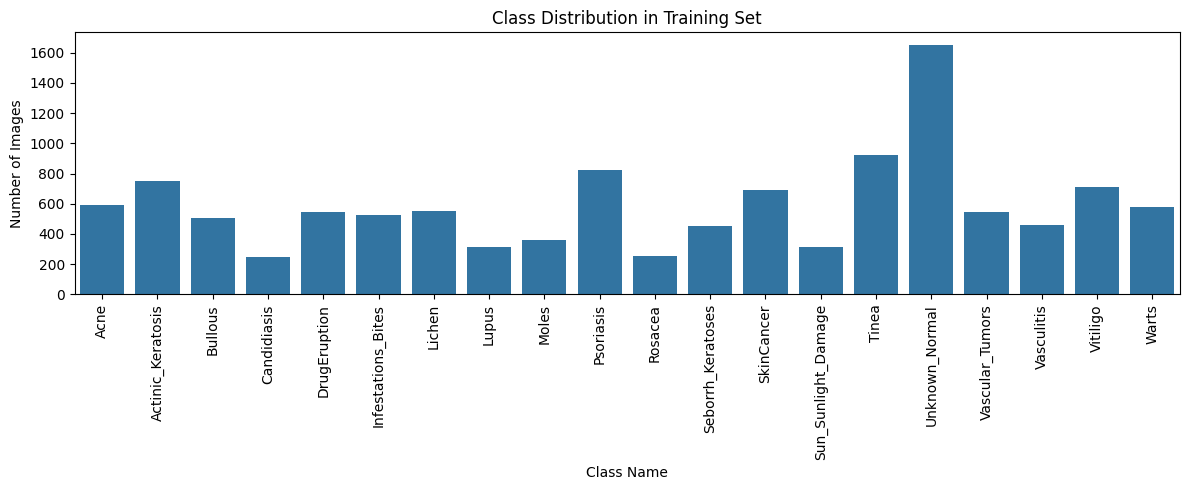

In [10]:
import seaborn as sns
from collections import Counter

# Class distribution bar chart
label_counts = Counter(train_ds.targets)
plt.figure(figsize=(12, 5))
sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

# 6. Compute Class Weights for Imbalance

This section calculates class weights to handle class imbalance in the dataset.

If some classes (diseases) have many more samples than others, the model may develop tendency to predict majority classes.

These class weights can be passed to the loss function during model training to improve performance on minority classes.

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
labels = [label for _, label in train_ds.samples]
class_weights = compute_class_weight('balanced', classes=np.arange(len(train_ds.classes)), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.9945, 0.7884, 1.1701, 2.3780, 1.0782, 1.1255, 1.0665, 1.8963, 1.6337,
        0.7192, 2.3219, 1.2962, 0.8510, 1.8902, 0.6389, 0.3572, 1.0861, 1.2793,
        0.8260, 1.0168], device='cuda:0')


# 7. Define Model, Loss Function, Optimizer & Scheduler
- Initialize ConvNeXt-Tiny model with pretrained weights for skin disease classification.

- Set up CrossEntropyLoss as loss function with class weights to handle imbalance.

- Configure AdamW optimizer for efficient gradient updates.

- Add a CosineAnnealingLR scheduler to adjust learning rate dynamically during training.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. Initialize an Advanced Model (ConvNeXt)
# ConvNeXt-Tiny is a great balance of speed and state-of-the-art accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 20

model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)

# Update the classifier head

n_inputs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(n_inputs, num_classes)
model = model.to(device)

# 2. Advanced Optimizer and Loss
# AdamW is superior for modern architectures like ConvNeXt and Transformers

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# LabelSmoothing helps prevent the model from becoming overconfident

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Cosine Annealing is often more effective for advanced models than StepLR

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print("\n")
print(model)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 195MB/s]




ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_feature

# 8. Implement Training Loop
This section implements the training and validation loop for the ConvNeXt model, including early stopping and saving the best-performing model.


In [13]:
# --- Training Loop ---

EPOCHS = 20
best_val_acc = 0
patience, counter = 10, 0
checkpoint_path = "best_convnext_model.pth"

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = train_correct = train_total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Optional: Gradient Clipping (prevents exploding gradients in advanced models)

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    model.eval()

    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Update scheduler

    scheduler.step()

    print(f"Epoch {epoch}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print("📌 Best model saved.")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping.")
            break

# Load best weights

model.load_state_dict(torch.load(checkpoint_path))

print("✅ Training complete; best ConvNeXt model loaded.")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 | Train Acc: 0.5280 | Val Acc: 0.6687 | LR: 0.000099
📌 Best model saved.
Epoch 2/20 | Train Acc: 0.7635 | Val Acc: 0.7525 | LR: 0.000098
📌 Best model saved.
Epoch 3/20 | Train Acc: 0.8750 | Val Acc: 0.7669 | LR: 0.000095
📌 Best model saved.
Epoch 4/20 | Train Acc: 0.9279 | Val Acc: 0.7959 | LR: 0.000090
📌 Best model saved.
Epoch 5/20 | Train Acc: 0.9545 | Val Acc: 0.7906 | LR: 0.000085
Epoch 6/20 | Train Acc: 0.9659 | Val Acc: 0.7852 | LR: 0.000079
Epoch 7/20 | Train Acc: 0.9763 | Val Acc: 0.8096 | LR: 0.000073
📌 Best model saved.
Epoch 8/20 | Train Acc: 0.9827 | Val Acc: 0.8043 | LR: 0.000065
Epoch 9/20 | Train Acc: 0.9852 | Val Acc: 0.8081 | LR: 0.000058
Epoch 10/20 | Train Acc: 0.9880 | Val Acc: 0.8218 | LR: 0.000050
📌 Best model saved.
Epoch 11/20 | Train Acc: 0.9915 | Val Acc: 0.8203 | LR: 0.000042
Epoch 12/20 | Train Acc: 0.9940 | Val Acc: 0.8172 | LR: 0.000035
Epoch 13/20 | Train Acc: 0.9949 | Val Acc: 0.8210 | LR: 0.000027
Epoch 14/20 | Train Acc: 0.9947 | Val Acc: 0

# 9. Evaluation on Test Set
This section evaluates the trained model on test set using a detailed classification report.  
The report provides precision, recall, F1-score, and support for each class.

In [14]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

                     precision    recall  f1-score   support

               Acne       0.90      0.94      0.92        65
  Actinic_Keratosis       0.79      0.88      0.83        83
            Bullous       0.70      0.71      0.70        55
        Candidiasis       0.71      0.81      0.76        27
       DrugEruption       0.74      0.79      0.76        61
 Infestations_Bites       0.76      0.63      0.69        60
             Lichen       0.84      0.80      0.82        61
              Lupus       0.70      0.62      0.66        34
              Moles       0.67      0.78      0.72        40
          Psoriasis       0.88      0.85      0.87        88
            Rosacea       0.74      0.89      0.81        28
  Seborrh_Keratoses       0.87      0.80      0.84        51
         SkinCancer       0.76      0.81      0.78        77
Sun_Sunlight_Damage       0.68      0.68      0.68        34
              Tinea       0.86      0.79      0.83       102
     Unknown_Normal    

# 10. Confusion Matrix for Skin Disease Classification

This section evaluates the trained  model by computing and visualizing the confusion matrix on the validation dataset.  
It helps to identify which classes are correctly predicted and which are often misclassified.


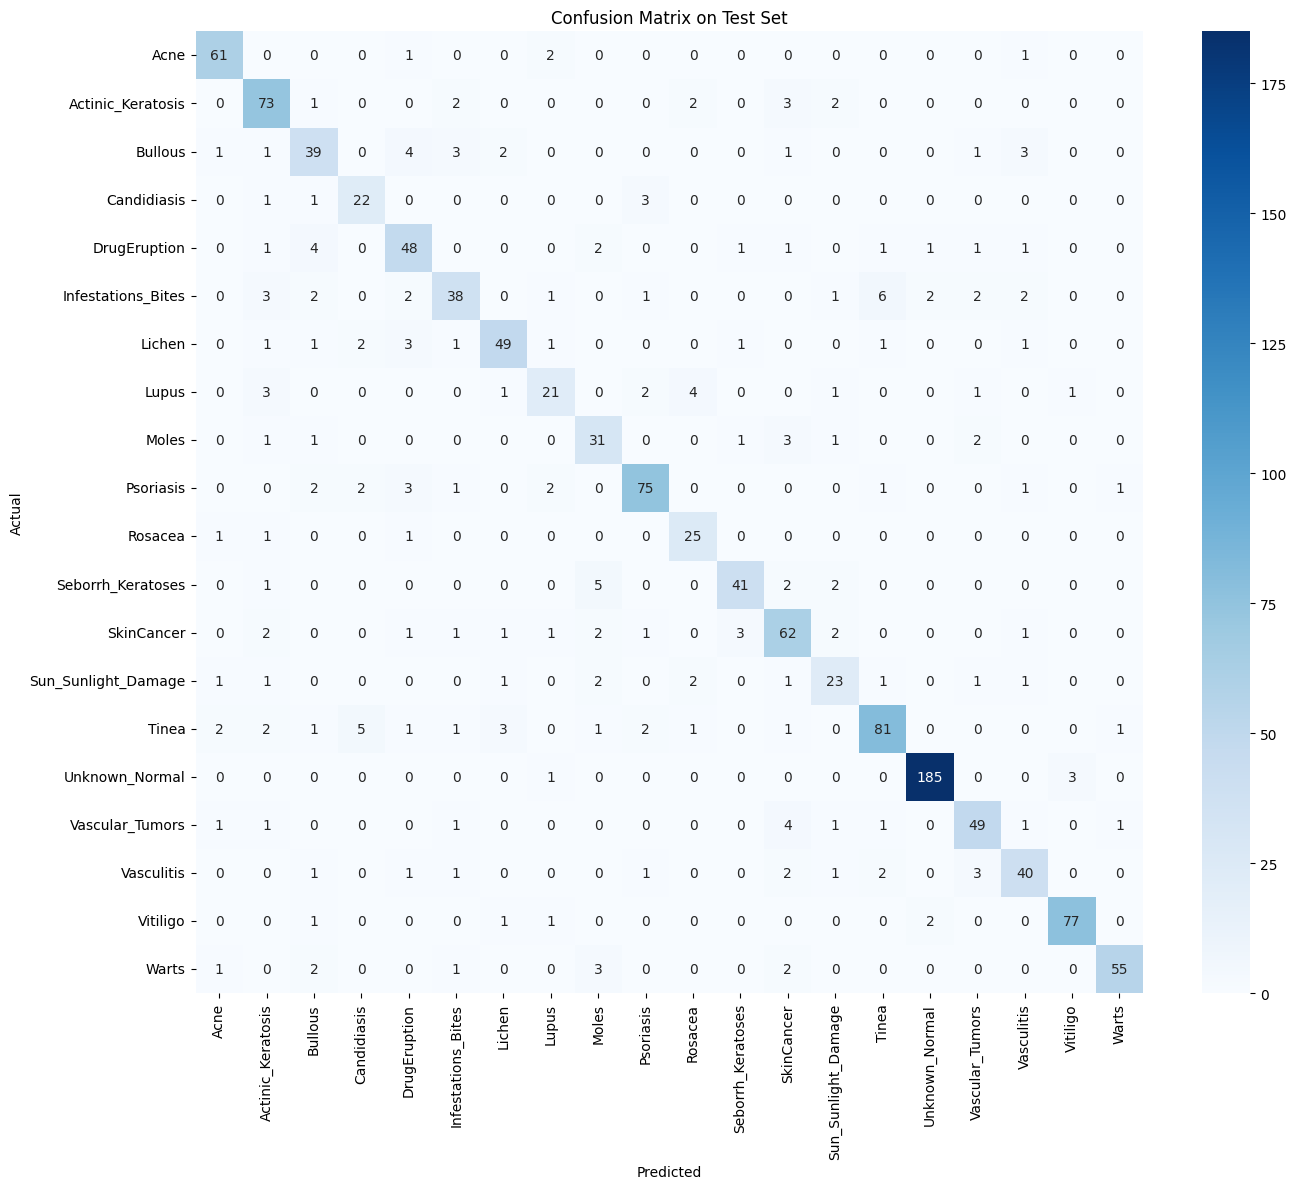

In [15]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = val_ds.classes

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 11. Prediction
This section demonstrates how to load a trained ConvNeXt model and use it to predict the skin disease class for input image.


✅ Loaded weights from /content/best_convnext_model.pth


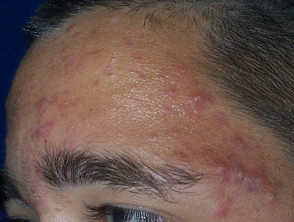


--- Prediction Results ---
Disease   : Acne
Confidence: 89.53%


In [16]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models  # Using torchvision for ConvNeXt
from PIL import Image
from IPython.display import display
import os

# ------------------------------
# Image to predict
# ------------------------------
image_path = "/content/skindiseasedataset/SkinDisease/SkinDisease/test/Acne/acne-face-1__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Class names
# ------------------------------
class_names = ['Acne', 'Actinic_Keratosis', 'Bullous', 'Candidiasis', 'DrugEruption',
               'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis',
               'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage',
               'Tinea', 'Unknown', 'Vascular_Tumors', 'Vasculitis',
               'Vitiligo', 'Warts']
NUM_CLASSES = len(class_names)

# ------------------------------
# Load ConvNeXt Model
# ------------------------------
# Initialize the architecture
model = models.convnext_tiny(weights=None)

# Adjust the classifier head specifically for ConvNeXt-Tiny
# ConvNeXt's classifier is: (0): LayerNorm, (1): Flatten, (2): Linear
n_inputs = model.classifier[2].in_features
model.classifier[2] = torch.nn.Linear(n_inputs, NUM_CLASSES)

# Load trained model weights
checkpoint_path = "/content/best_convnext_model.pth"
if os.path.exists(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded weights from {checkpoint_path}")
else:
    print(f"⚠️ Warning: Checkpoint not found at {checkpoint_path}. Using uninitialized weights.")

model.to(device)
model.eval()

# ------------------------------
# Image preprocessing (ImageNet Standards)
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ------------------------------
# Function to predict single image
# ------------------------------
def predict_single_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Preprocess and predict
    # 1. Apply transforms 2. Add batch dimension (.unsqueeze(0)) 3. Move to device
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, 1)

    prediction = class_names[pred.item()]
    conf_value = confidence.item() * 100

    # Display image and prediction
    display(image)
    print(f"\n--- Prediction Results ---")
    print(f"Disease   : {prediction}")
    print(f"Confidence: {conf_value:.2f}%")

predict_single_image(image_path)